## Bayesian Decision Making 1

Consider this problem taken from "An Introduction to Bayesian Inference and Decision" by Robert L. Winkler:

>A hot-dog vendor at a football game must decide in advance how many hot dogs to order. He makes a profit of \$0.10 on 
each hot dog that is sold, and he suffers a \$0.20 loss on hot dogs that are unsold. If his distribution of the number of hot dogs that will be demanded at the football game is a normal distribution with mean 10,000 and standard deviation 2000, how many hot dogs should he order?

Let's tackle this problem in simulation. Since we know the underlying distribution, we can randomly generate a dataset (D) to simulate the demand the hot-dog vendor has documented over a fair number of games (N). Let's pick N = 50 as our vendor remembers learning the Central Limit Theorem and knows he should use more than 30 samples to model his distribution.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

mean  = 10000
sigma = 2000
N = 50

D = np.random.normal(mean, sigma, N)
D = np.round(D)

The vendor can now take the data that he has collected and model the distribution with a histogram. He then concludes that given the data he has collected the distribution is likely gaussian and decides to solve for the mean (meanD) and standard deviation (sigmaD) of his collected data. He can then use the mean and sigma to find a pdf for his distribution.

It is important to pick an appropriate number of bins based on the number of samples obtained in order to see the underlying distribution. Too many or too few bins in the histogram will not help inform a good model of the distribution.
Also note that the pdf we solve for below does not account for the entire bin. However, this is okay as we'll recompute a higher resolution pdf to use for later calculations.

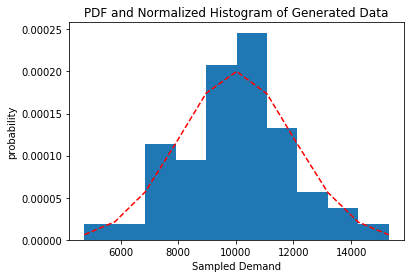

In [2]:
num_bins = 10

plt.figure()
n, bins, patches = plt.hist(D, num_bins, normed=1)

meanD = np.mean(D)
sigmaD = np.sqrt(np.var(D))
y = norm.pdf(bins, meanD, sigmaD)
plt.plot(bins, y, 'r--')
plt.title('PDF and Normalized Histogram of Generated Data')
plt.xlabel('Sampled Demand')
plt.ylabel('probability')
plt.show()

The histogram and PDF above are nice to inform the distribution. But our vendor is going to want more resolution in his decision than just in the few bins above! It should be safe to assume that our vendor buys in bulk and doesn't need to make the decision down to the individual level. We can then step by a moderately sized number (50-150) to give more granularity to the decision.

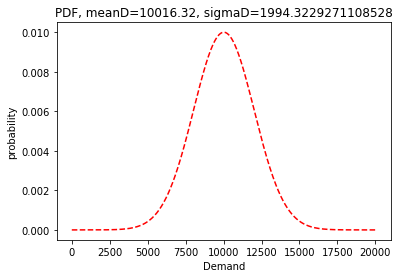

In [3]:
h = 50
Range = np.arange(0,2*meanD+h,h)
prob_demand = norm.pdf(Range, meanD, sigmaD)*h

plt.figure()
plt.plot(Range, prob_demand, 'r--')
plt.title('PDF, meanD='+str(meanD)+', sigmaD='+str(sigmaD))
plt.xlabel('Demand')
plt.ylabel('probability')
plt.show()

So now that our vendor has modeled his underlying distribution. He'll need to determine a loss function. Of course we determine the loss function based on the profit and loss for sold and unsold hotdogs given in the problem statement. There are two possibilities:

1. The supply of hotdogs the vendor ordered is less than or equal to the demand for hotdogs ($s \leq d$):  
In this case the vendor will sell out and will have zero unsold hotdogs. Therefore his profit will just be 10 cents times the supply he had:  
$Profit = 0.1 \times s$

2. The supply is greater than the demand ($s > d$):  
Now he gains on selling the amount demanded however incurs losses on each unsold hotdog above the amount demanded ($s - d$). So his profit function will be:  
$Profit = 0.1 \times d - 0.2 \times (s-d)$

We can combine both of these cases into the following function:  
$G(s,d) = 0.1 \times \textrm{min}[s,d] - 0.2 \times \textrm{max}[0,(s-d)]$  
From here, we could implement our decision based on this Gain function to find an expected gain for each possible supply amount then find the decision by maximizing the expected gain.

However let's stick to the conventional Loss function which we can find by negating the Gain function above:  
$\textrm{L}(s,d) = -(0.1 \times \textrm{min}[s,d] - 0.2 \times \textrm{max}[0,(s-d)])$  
Our decision will then be the minimum expected loss in our decision space. First let's calculate the loss for each possible supply and demand combination in our decision space.

Note: The decision found from either method will be the same.  

In [4]:
i = 0
L = np.zeros([np.size(Range),np.size(Range)])
for d in Range:
    j = 0
    for s in Range:
        L[i,j] = -(.1*np.min([s,d])-.2*np.max([0,s-d]))
        j += 1
    i += 1

Since we now have both the probabilty distribution for demand as well as all the possible losses in the decision space, we can compute the Expected Loss function (EL) for a decision (number of supply to ordered). The Expected Loss for an action is defined as the sum of over the possible values of the random variable of the Loss times the probability of the corresponding value for the random variable. For us, in equation form:  
$\textrm{EL}(s) = \sum\limits_{d} \textrm{L}(s,d) \times \textrm{P}(d)$  

Once we find this Expected Loss function, we determine the appropriate decision by finding decision that gives the minimum Expected Loss. In our case a negative loss corresponds to profit.

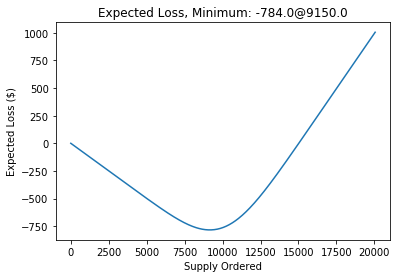

In [5]:
prob_demand_mat = np.tile(prob_demand,(np.size(Range),1)).T
EL = np.sum(np.multiply(L,prob_demand_mat), 0)
minInd = np.argmin(EL)
Min = EL[minInd]
Decision = Range[minInd]

plt.figure()
plt.plot(Range, EL)
plt.title('Expected Loss, Minimum: ' + str(round(Min)) + '@' + str(Decision))
plt.xlabel('Supply Ordered')
plt.ylabel('Expected Loss ($)')
plt.show()